In [1]:
import xarray as xr

In [2]:
ds = xr.open_dataset("../output/grids/a3d_grids.nc")
var='swe'
ds

<xarray.Dataset>
Dimensions:                (easting: 168, northing: 107, time: 2)
Coordinates:
  * time                   (time) datetime64[ns] 1980-01-01T01:00:00 1980-01-01T02:00:00
  * northing               (northing) float32 -109000.0 -108000.0 ... -3000.0
  * easting                (easting) float32 -1542000.0 ... -1375000.0
Data variables:
    dw                     (time, northing, easting) float32 ...
    snd                    (time, northing, easting) float32 ...
    rlds                   (time, northing, easting) float32 ...
    rsds                   (time, northing, easting) float32 ...
    MS_SNOWPACK_RUNOFF     (time, northing, easting) float32 ...
    pr                     (time, northing, easting) float32 ...
    hur                    (time, northing, easting) float32 ...
    snow_density           (time, northing, easting) float32 ...
    SFC_SUBL               (time, northing, easting) float32 ...
    SURF_ALB               (time, northing, easting) float32 ...
    swe                    (time, northing, easting) float32 ...
    ta                     (time, northing, easting) float32 ...
    TOP_ALB                (time, northing, easting) float32 ...
    TSG                    (time, northing, easting) float32 ...
    ts                     (time, northing, easting) float32 ...
    ws                     (time, northing, easting) float32 ...
    VW_DRIFT               (time, northing, easting) float32 ...
    WINDEROSIONDEPOSITION  (time, northing, easting) float32 ...
Attributes:
    date_created:              2020-08-21
    creator_name:              erke2265
    source:                    MeteoIO-2.81
    history:                   2020-08-21T21:56:31Z, erke2265@shas0107.rc.int...
    keywords_vocabulary:       AGU Index Terms
    keywords:                  Cryosphere, Mass Balance, Energy Balance, Atmo...
    title:                     Gridded data for various parameters and timesteps
    institution:               colorado.edu
    product_version:           1.0
    Conventions:               CF-1.6,ACDD-1.3
    standard_name_vocabulary:  CF-1.6
    cdm_data_type:             Grid
    geospatial_bounds_crs:     EPSG:3031
    geospatial_bounds:         Polygon ((-1542000.0000000000 -109000.00000000...

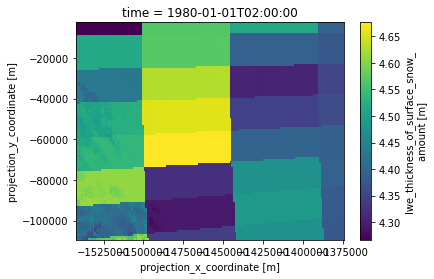

In [3]:
ds[var][-1,:,:].plot()

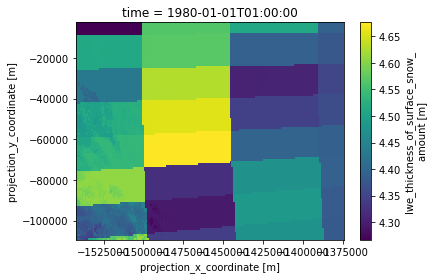

In [4]:
ds[var][0,:,:].plot()

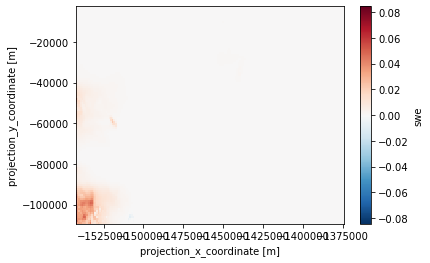

In [5]:
dswe = ds[var][-1,:,:] - ds[var][0,:,:]
dswe.plot()

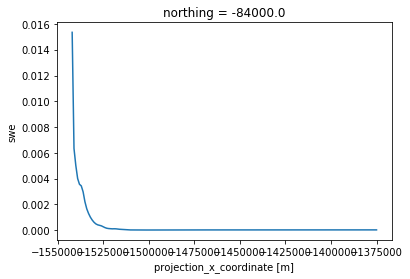

In [6]:
dswe.sel(northing=-84000).plot()

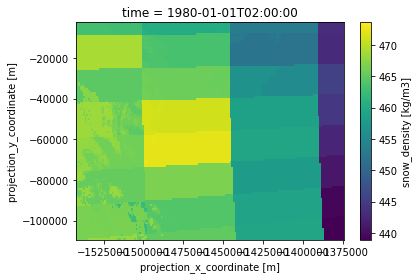

In [7]:
ds['snow_density'][-1,:,:].plot()

In [8]:
dswe.mean(dim='northing').mean(dim='easting')

<xarray.DataArray 'swe' ()>
array(0.00088758, dtype=float32)

In [9]:
ds

<xarray.Dataset>
Dimensions:                (easting: 168, northing: 107, time: 2)
Coordinates:
  * time                   (time) datetime64[ns] 1980-01-01T01:00:00 1980-01-01T02:00:00
  * northing               (northing) float32 -109000.0 -108000.0 ... -3000.0
  * easting                (easting) float32 -1542000.0 ... -1375000.0
Data variables:
    dw                     (time, northing, easting) float32 8.820955 ... 13.3815975
    snd                    (time, northing, easting) float32 9.327043 ... 9.914017
    rlds                   (time, northing, easting) float32 185.39651 ... 165.91353
    rsds                   (time, northing, easting) float32 351.06073 ... 284.65042
    MS_SNOWPACK_RUNOFF     (time, northing, easting) float32 0.0 0.0 ... 0.0 0.0
    pr                     (time, northing, easting) float32 0.0 ... 0.00023432956
    hur                    (time, northing, easting) float32 0.8927049 ... 0.9773316
    snow_density           (time, northing, easting) float32 466.48834 ... 443.29227
    SFC_SUBL               (time, northing, easting) float32 0.010047557 ... -0.01332095
    SURF_ALB               (time, northing, easting) float32 0.3 0.3 ... 0.3 0.3
    swe                    (time, northing, easting) float32 4.3509564 ... 4.3948073
    ta                     (time, northing, easting) float32 262.79016 ... 259.4513
    TOP_ALB                (time, northing, easting) float32 0.3 0.3 ... 0.3 0.3
    TSG                    (time, northing, easting) float32 247.80943 ... 243.82872
    ts                     (time, northing, easting) float32 261.28128 ... 256.14136
    ws                     (time, northing, easting) float32 25.034565 ... 4.3019176
    VW_DRIFT               (time, northing, easting) float32 25.034565 ... 4.3019176
    WINDEROSIONDEPOSITION  (time, northing, easting) float32 0.0 0.0 ... 0.0 0.0
Attributes:
    date_created:              2020-08-21
    creator_name:              erke2265
    source:                    MeteoIO-2.81
    history:                   2020-08-21T21:56:31Z, erke2265@shas0107.rc.int...
    keywords_vocabulary:       AGU Index Terms
    keywords:                  Cryosphere, Mass Balance, Energy Balance, Atmo...
    title:                     Gridded data for various parameters and timesteps
    institution:               colorado.edu
    product_version:           1.0
    Conventions:               CF-1.6,ACDD-1.3
    standard_name_vocabulary:  CF-1.6
    cdm_data_type:             Grid
    geospatial_bounds_crs:     EPSG:3031
    geospatial_bounds:         Polygon ((-1542000.0000000000 -109000.00000000...

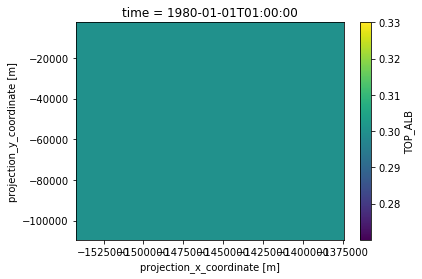

In [11]:
ds['TOP_ALB'].isel(time=0).plot()